# Modelling and Evaluation Notebook- Predict Sale Price

## Objectives

*   Fit and evaluate a Regression model to predict sale price


## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics'

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF' ], axis=1)  
  )

print(df.shape)
df.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

# ML Pipeline with all data

## ML pipeline for Data Cleaning 

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import feature_engine.transformation as vt 

# Custom Transformer for Ordinal Encoding with Mappings
class OrdinalMappingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        self.mappings = mappings
    
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X):
        X = X.copy()
        for column, mapping in self.mappings.items():
            if column in X.columns:
                X[column] = X[column].map(mapping)
        return X

# Define mappings for ordinal encoding
mappings = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'Missing': -1, 'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'Missing': -1, 'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
}

ordinal_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

# Instantiate the custom transformer
ordinal_mapping_transformer = OrdinalMappingTransformer(mappings=mappings)

def DataCleaningPipeline():
    # Impute missing values for categorical columns
    categorical_imputer = CategoricalImputer(
        imputation_method='missing', 
        fill_value='Missing', 
        variables=['GarageFinish', 'BsmtFinType1']
    )
    
    # Impute missing values for numeric columns
    mean_median_imputer = MeanMedianImputer(
        imputation_method='median',
        variables=['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BedroomAbvGr', '2ndFlrSF']
    )
    
    data_cleaning_pipeline = Pipeline(steps=[
        ('categorical_imputer', categorical_imputer),
        ('mean_median_imputer', mean_median_imputer),
        ('ordinal_mapping_transformer', OrdinalMappingTransformer(mappings))  
    ])
    
    return data_cleaning_pipeline


Check results of data cleaning

In [7]:
cleaning_pipeline = DataCleaningPipeline()
transformed_data = cleaning_pipeline.fit_transform(df)
print(transformed_data[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].head())
for column in ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']:
    print(f"{column}: {transformed_data[column].unique()}")

# Check the data types
print(transformed_data[ordinal_columns].dtypes)

# Confirm encoding
for column in ordinal_columns:
    print(f"{column}: {transformed_data[column].unique()}")

# Check for any remaining missing values
print(transformed_data[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].isnull().sum())
print(transformed_data.columns)

   BsmtExposure  BsmtFinType1  GarageFinish  KitchenQual
0             1             6             2            4
1             4             5             2            3
2             2             6             2            4
3             1             5             1            4
4             3             6             2            4
BsmtExposure: [1 4 2 3 0]
BsmtFinType1: [ 6  5  1  3 -1  4  0  2]
GarageFinish: [ 2  1 -1  3  0]
KitchenQual: [4 3 5 2]
BsmtExposure    int64
BsmtFinType1    int64
GarageFinish    int64
KitchenQual     int64
dtype: object
BsmtExposure: [1 4 2 3 0]
BsmtFinType1: [ 6  5  1  3 -1  4  0  2]
GarageFinish: [ 2  1 -1  3  0]
KitchenQual: [4 3 5 2]
BsmtExposure    0
BsmtFinType1    0
GarageFinish    0
KitchenQual     0
dtype: int64
Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish',
       'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage',
       'MasV

## ML pipeline for Feature Engineering

In [8]:
# Columns that require transformation
yeo_johnson_columns = ['1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF']  
power_transformer_columns = ['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'TotalBsmtSF']  
log_transformer_columns = ['LotFrontage']

def FeatureEngineeringPipeline():
    return Pipeline([
        # Apply Yeo-Johnson transformation
        ('yeo_johnson', vt.YeoJohnsonTransformer(variables=yeo_johnson_columns)),

        # Apply PowerTransformer to specific columns
        ("power_transform", vt.PowerTransformer(variables=power_transformer_columns)),

        # Apply log transformation
        ("log_transform", vt.LogTransformer(variables=log_transformer_columns)),
    ])


def PreprocessingPipeline():
    data_cleaning_pipeline = DataCleaningPipeline()  
    feature_engineering_pipeline = FeatureEngineeringPipeline()

    preprocessing_pipeline = Pipeline(steps=[
        ('data_cleaning', data_cleaning_pipeline),
        ('feature_engineering', feature_engineering_pipeline),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        
    ])
    return preprocessing_pipeline


def FullPipeline(model):
    preprocessing_pipeline = PreprocessingPipeline()

    full_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('feat_scaling', StandardScaler()), 
        ("feat_selection",  SelectFromModel(model)),
        ('model', model)
    ])
    return full_pipeline

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = FullPipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error

# Define models and parameters
models = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [12]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

Results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.665303,0.759882,0.802081,0.048815
5,GradientBoostingRegressor,0.643137,0.757346,0.834133,0.062391
2,RandomForestRegressor,0.597511,0.743111,0.822028,0.084179
0,LinearRegression,0.702605,0.736456,0.797336,0.03242
6,XGBRegressor,0.584075,0.650841,0.71044,0.048526
4,AdaBoostRegressor,0.481665,0.64688,0.733679,0.103825
1,DecisionTreeRegressor,0.349506,0.552882,0.702111,0.124687


### Do an extensive search on the most suitable models to find the best hyperparameter configuration.

Test on all algorithms with a mean score of over or close to the target threshold- 0.75

In [14]:
models = {
    'LinearRegression': LinearRegression(),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params = {
    'LinearRegression': {},
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],  
        'model__learning_rate': [0.05, 0.1], 
        'model__max_depth': [3, 5],  
        'model__min_samples_split': [2, 5], 
        'model__min_samples_leaf': [1, 2],  
        'model__subsample': [0.8, 1.0],  
        'model__max_features': ['sqrt', None],
        'model__loss': ['huber']
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
        'model__bootstrap': [True, False],  
    },
}


In [15]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 128 candidates, totalling 640 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__subsample,model__bootstrap
61,GradientBoostingRegressor,0.73927,0.787777,0.832855,0.034049,3,None,2,5,100,0.05,huber,0.8,NaN
57,GradientBoostingRegressor,0.741027,0.787212,0.83201,0.033839,3,None,2,2,100,0.05,huber,0.8,NaN
129,GradientBoostingRegressor,0.722229,0.787026,0.83787,0.037111,5,sqrt,1,2,100,0.1,huber,0.8,NaN
53,GradientBoostingRegressor,0.743308,0.785468,0.833944,0.033597,3,None,1,5,100,0.05,huber,0.8,NaN
49,GradientBoostingRegressor,0.738589,0.785208,0.834218,0.034421,3,None,1,2,100,0.05,huber,0.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,RandomForestRegressor,0.499895,0.709251,0.830487,0.123141,None,0.5,1,5,100,NaN,NaN,NaN,False
210,RandomForestRegressor,0.509009,0.705978,0.830443,0.123105,None,sqrt,1,2,300,NaN,NaN,NaN,False
218,RandomForestRegressor,0.509009,0.705978,0.830443,0.123105,None,0.5,1,2,300,NaN,NaN,NaN,False
217,RandomForestRegressor,0.506004,0.705318,0.825646,0.123494,None,0.5,1,2,100,NaN,NaN,NaN,False


Best Model

In [17]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Best Parameters

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.05,
 'model__loss': 'huber',
 'model__max_depth': 3,
 'model__max_features': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

Best Pipeline

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('data_cleaning',
                                  Pipeline(steps=[('categorical_imputer',
                                                   CategoricalImputer(variables=['GarageFinish',
                                                                                 'BsmtFinType1'])),
                                                  ('mean_median_imputer',
                                                   MeanMedianImputer(variables=['LotFrontage',
                                                                                'GarageYrBlt',
                                                                                'MasVnrArea',
                                                                                'BedroomAbvGr',
                                                                                '2ndFlrSF'])),
                                                  ('ordinal_mapping_transformer',
             

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']


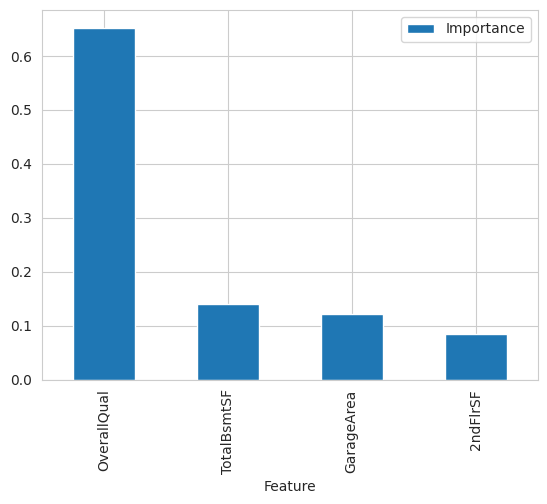

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.863
Mean Absolute Error: 19366.762
Mean Squared Error: 840583676.631
Root Mean Squared Error: 28992.821


* Test Set
R2 Score: 0.788
Mean Absolute Error: 23110.968
Mean Squared Error: 1462034472.338
Root Mean Squared Error: 38236.559




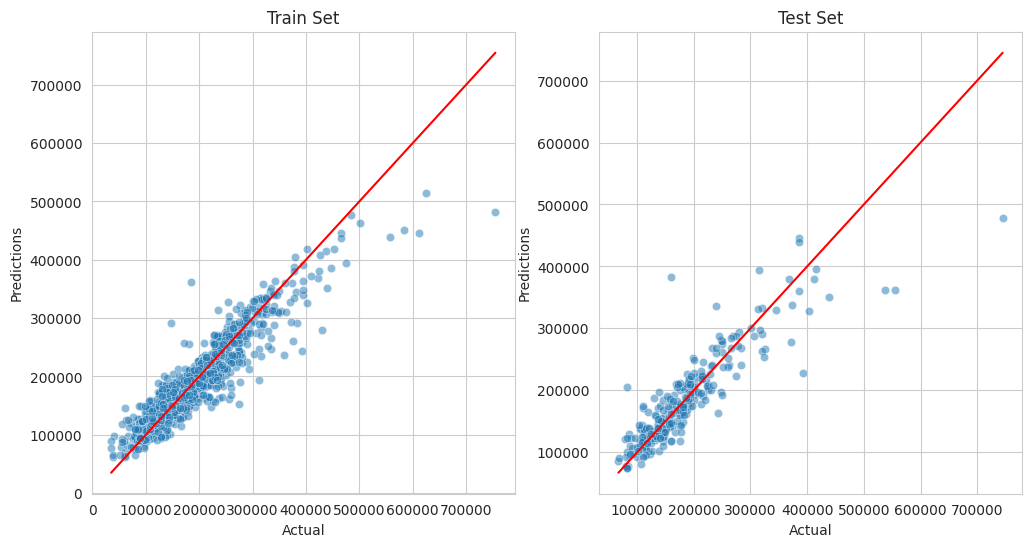

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

NOTE

* Train Set = R2 Score: 0.863, Test Set = R2 Score: 0.788. Both scores for the training and test sets are high without too much gap between, indicating that the model generalizes well without significant overfitting. 
* The required r2 score of 0.75 is exceeded in both train and test sets.
* The scatterplots show a strong positive correlation.

# Regressor with PCA

In [23]:
pipeline = FullPipeline(model=GradientBoostingRegressor())
pipeline_pca = Pipeline(pipeline.steps[:1])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 15) 
 <class 'pandas.core.frame.DataFrame'>


* The 15 components explain 100.0% of the data 



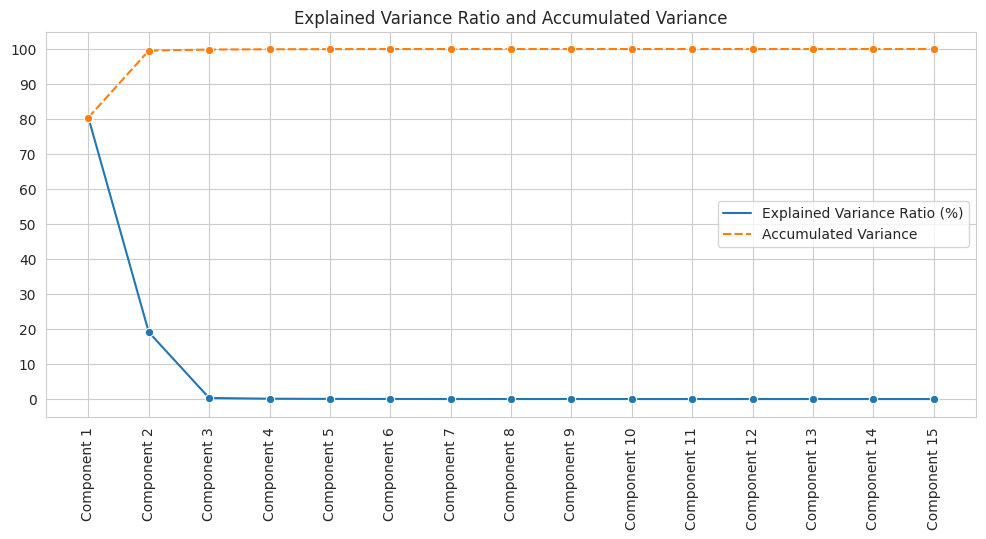

In [24]:
from sklearn.decomposition import PCA

n_components = 15

def pca_components_analysis(df_pca, n_components=None):
    # Automatically adjust n_components if not provided or too large
    max_components = min(df_pca.shape[0], df_pca.shape[1])
    if n_components is None or n_components > max_components:
        n_components = max_components
        print(f"Adjusted n_components to {n_components} (max possible components).")

    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number + 1)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained, 2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio, marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.title('Explained Variance Ratio and Accumulated Variance')
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

In [1]:
n_components = 5
pca_components_analysis(df_pca=df_pca, n_components=n_components)

NameError: name 'pca_components_analysis' is not defined

## Rewrite ML Pipeline for Modelling

In [26]:
# PCA
from sklearn.decomposition import PCA

# Columns that require transformation
yeo_johnson_columns = ['1stFlrSF', 'GrLivArea', 'LotArea', 'OpenPorchSF']  
power_transformer_columns = ['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'TotalBsmtSF']  
log_transformer_columns = ['LotFrontage'] 
age_transformer_columns = ['YearBuilt'] 
current_year = 2024

def FeatureEngineeringPipeline():
    return Pipeline(steps=[
        # Apply Yeo-Johnson transformation
        ('yeo_johnson', YeoJohnsonTransformer(variables=yeo_johnson_columns)),

        # Apply PowerTransformer to specific columns
        ('power_transform', FunctionTransformer(
            lambda X: pd.DataFrame(
                {
                    **X,
                    **{col: PowerTransformer().fit_transform(X[[col]])[:, 0] for col in power_transformer_columns}
                }
            )
        )),

        # Apply log transformation
        ('log_transform', FunctionTransformer(
            lambda X: X.assign(
                **{col: np.log1p(X[col]) for col in log_transformer_columns}
            )
        )),

        # Compute age from YearBuilt
        ('age_transform', FunctionTransformer(
            lambda X: X.assign(
                **{col: current_year - X[col] for col in age_transformer_columns}
            )
        )),
    ])


def PreprocessingPipeline():
    data_cleaning_pipeline = DataCleaningPipeline()  
    feature_engineering_pipeline = FeatureEngineeringPipeline()

    preprocessing_pipeline = Pipeline(steps=[
        ('data_cleaning', data_cleaning_pipeline),
        ('feature_engineering', feature_engineering_pipeline),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        
    ])
    return preprocessing_pipeline


def FullPipeline(model):
    preprocessing_pipeline = PreprocessingPipeline()

    full_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('feat_scaling', StandardScaler()), 
        ("PCA", PCA(n_components=3, random_state=0)),
        ('model', model)
    ])
    return full_pipeline

## Grid searchCV

In [27]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Use standard hyperparameters to find the best model

In [28]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick optimisation search

In [29]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Check Results

In [30]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.623436,0.691957,0.75966,0.051481
5,GradientBoostingRegressor,0.537825,0.687617,0.773634,0.086688
4,AdaBoostRegressor,0.608852,0.668848,0.760951,0.056528
0,LinearRegression,0.635323,0.666106,0.717374,0.027429
3,ExtraTreesRegressor,0.56158,0.65579,0.730697,0.056963
6,XGBRegressor,0.533481,0.642568,0.73632,0.083862
1,DecisionTreeRegressor,0.273686,0.473776,0.637432,0.124721


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

In [31]:
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
        'model__bootstrap': [True, False],  
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],  
        'model__learning_rate': [0.05, 0.1], 
        'model__max_depth': [3, 5],  
        'model__min_samples_split': [2, 5], 
        'model__min_samples_leaf': [1, 2],  
        'model__subsample': [0.8, 1.0],  
        'model__max_features': ['sqrt'],
    },
    
}

Extensive GridSearch CV

In [32]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

Check results

In [33]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__subsample
96,GradientBoostingRegressor,0.662503,0.725249,0.786149,0.044478,NaN,3,sqrt,1,2,100,0.1,0.8
77,GradientBoostingRegressor,0.697391,0.72297,0.76888,0.02743,NaN,3,sqrt,2,5,100,0.05,1.0
100,GradientBoostingRegressor,0.654576,0.72295,0.782882,0.0442,NaN,3,sqrt,1,5,100,0.1,0.8
68,GradientBoostingRegressor,0.678749,0.722669,0.769423,0.031893,NaN,3,sqrt,1,5,100,0.05,0.8
76,GradientBoostingRegressor,0.687648,0.721782,0.768765,0.030116,NaN,3,sqrt,2,5,100,0.05,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,GradientBoostingRegressor,0.620309,0.666889,0.757657,0.047182,NaN,5,sqrt,1,2,300,0.1,0.8
123,GradientBoostingRegressor,0.628983,0.662952,0.748267,0.044274,NaN,5,sqrt,2,2,300,0.1,1.0
126,GradientBoostingRegressor,0.612202,0.66196,0.740277,0.046152,NaN,5,sqrt,2,5,300,0.1,0.8
127,GradientBoostingRegressor,0.60938,0.659212,0.752124,0.048901,NaN,5,sqrt,2,5,300,0.1,1.0


Best Model

In [34]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [35]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

Define the best Regressor

In [36]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('data_cleaning',
                                  Pipeline(steps=[('categorical_imputer',
                                                   CategoricalImputer(variables=['GarageFinish',
                                                                                 'BsmtFinType1'])),
                                                  ('mean_median_imputer',
                                                   MeanMedianImputer(variables=['LotFrontage',
                                                                                'GarageYrBlt',
                                                                                'MasVnrArea',
                                                                                'BedroomAbvGr',
                                                                                '2ndFlrSF'])),
                                                  ('ordinal_mapping_transformer',
             

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.867
Mean Absolute Error: 20604.413
Mean Squared Error: 821812521.563
Root Mean Squared Error: 28667.273


* Test Set
R2 Score: 0.748
Mean Absolute Error: 27663.718
Mean Squared Error: 1742117831.918
Root Mean Squared Error: 41738.685




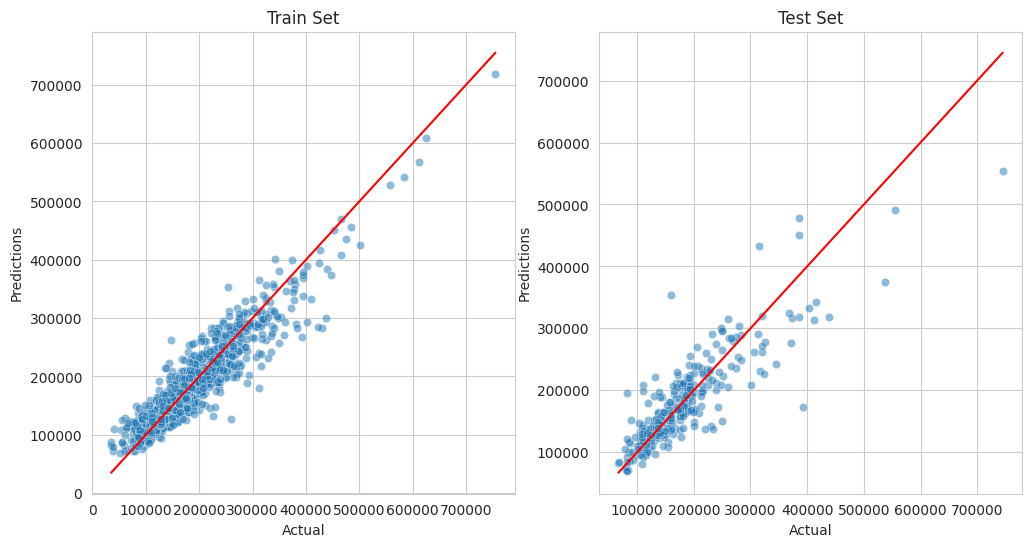

In [37]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Which pipeline to choose?

2 pipelines were fitted:
* Regression
* Regression with PCA

* The regressor pipeline showed the best results with 0.863 for Train and 0.788 for Test set, meeting the business requirements.
* Regression with PCA showed 0.867 for Train but only 0.748 for the test set. The difference between sets also indicates moderate overfitting and does not meet the threshold of 0.75 for both sets.

# Refit pipeline with best features

## Rewrite Pipeline

In [52]:
def FullPipeline(model):
    
    full_pipeline = Pipeline(steps=[
        # Impute missing values
        ("mean_median_imputer", MeanMedianImputer(
            imputation_method='median',
            variables=['2ndFlrSF']
        )),

        # Apply PowerTransformer to specific columns
        ("power_transform", vt.PowerTransformer(variables=['TotalBsmtSF'])),

        ('feat_scaling', StandardScaler()),

        ('model', model)
    ])
    
    return full_pipeline

## Split Train Test Set, only with best features

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Subset best features

In [54]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,2ndFlrSF,GarageArea,OverallQual,TotalBsmtSF
618,0.0,774,9,1822
870,0.0,308,5,894
92,0.0,432,5,876


## Grid Search CV – Sklearn

Model

Best Parameters

In [55]:
models = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params= {
    "GradientBoostingRegressor": {
        'model__learning_rate': [0.05],
        'model__loss': ['huber'],
        'model__max_depth': [3],
        'model__max_features': [None],
        'model__min_samples_leaf': [2],
        'model__min_samples_split': [5],
        'model__n_estimators': [100],
        'model__subsample': [0.8],
    }
}

GridSearch CV

In [56]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [57]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__loss,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
0,GradientBoostingRegressor,0.73927,0.792003,0.829152,0.037838,0.05,huber,3,None,2,5,100,0.8


Check the best Model

In [58]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Best Params

In [59]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.05,
 'model__loss': 'huber',
 'model__max_depth': 3,
 'model__max_features': None,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

Define the best pipeline

In [60]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('mean_median_imputer',
                 MeanMedianImputer(variables=['2ndFlrSF'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, loss='huber',
                                           min_samples_leaf=2,
                                           min_samples_split=5, random_state=0,
                                           subsample=0.8))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']


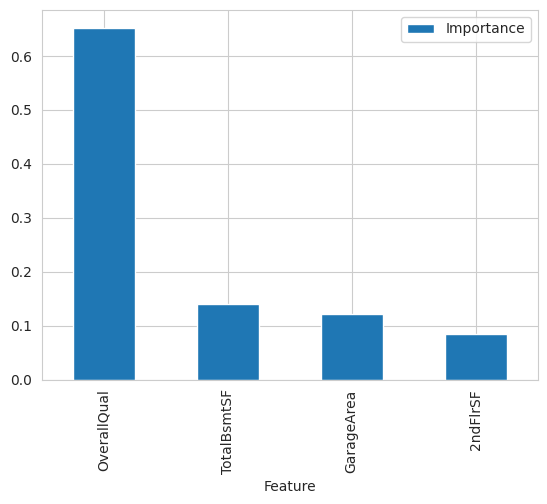

In [72]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Regressor on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.863
Mean Absolute Error: 19366.762
Mean Squared Error: 840583676.631
Root Mean Squared Error: 28992.821


* Test Set
R2 Score: 0.788
Mean Absolute Error: 23110.968
Mean Squared Error: 1462034472.338
Root Mean Squared Error: 38236.559




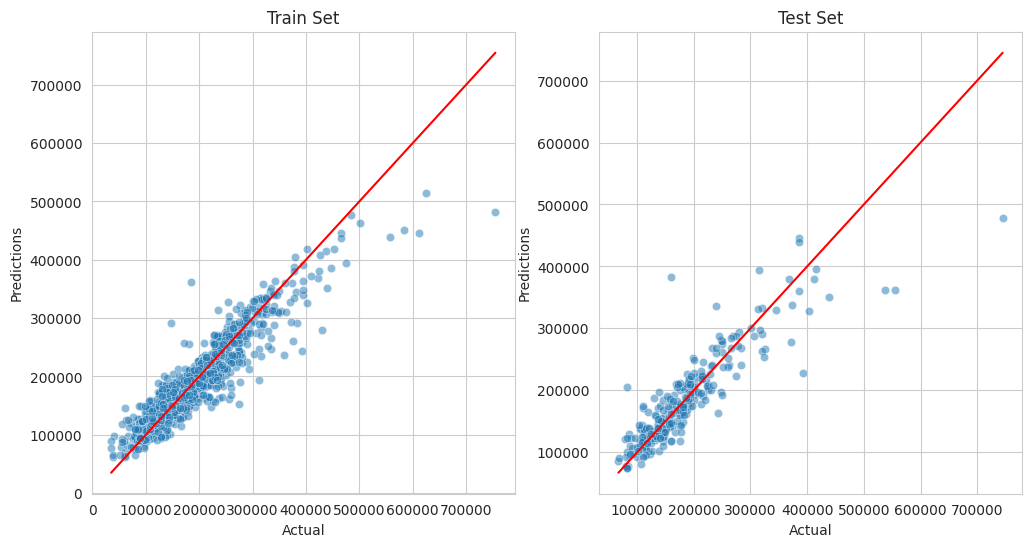

In [73]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

## Evaluation

* Both Train and Test sets provide good R2 scores and are above the target threshold of 0.75, although there is some variance suggesting slight overfitting. 
* Looking back at my correlation study, OverallQual, TotalBsmtSF and GarageArea showed high correlation with the target variable, Sale Price. 
* GrLivArea had very high corellation with the target, 2nd in both Pearson and Spearman methods. 
* 2ndFlrSF has 86 missing variables and 781 zeros. Although this could show that having a 2nd floor or not would affect the sale price, I would like to see if GrLivArea will improve the r2 score overall and provide a more accurate model.

## Refit ML Pipeline

Replace 2ndFlrSF with GrLivArea for reasons specified above

In [74]:
selected_features = ['OverallQual', 'TotalBsmtSF', 'GarageArea', 'GrLivArea']

In [75]:
def FullPipeline(model):
    
    full_pipeline = Pipeline(steps=[
        # Apply Yeo-Johnson transformation
        ('yeo_johnson', vt.YeoJohnsonTransformer(variables=['GrLivArea'])),

        # Apply PowerTransformer to specific columns
        ("power_transform", vt.PowerTransformer(variables=['TotalBsmtSF'])),

        ('feat_scaling', StandardScaler()),

        ('model', model)
    ])
    
    return full_pipeline

## Split Train Test Set, only with best features

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Subset selected features

In [77]:
X_train = X_train.filter(selected_features)
X_test = X_test.filter(selected_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,OverallQual,TotalBsmtSF,GarageArea,GrLivArea
618,9,1822,774,1828
870,5,894,308,894
92,5,876,432,964


## Grid Search CV – Sklearn

Check the most suitable alghorithm

In [78]:
models = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [79]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [80]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.68501,0.800732,0.852727,0.06212
3,ExtraTreesRegressor,0.660997,0.791119,0.856471,0.07066
5,GradientBoostingRegressor,0.636245,0.760776,0.842895,0.082001
0,LinearRegression,0.701601,0.757431,0.802496,0.034566
6,XGBRegressor,0.582021,0.747299,0.811628,0.084263
4,AdaBoostRegressor,0.555706,0.719706,0.77628,0.082728
1,DecisionTreeRegressor,0.499433,0.624097,0.712554,0.092624


In [81]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Extensive Search against best alghorithms

In [83]:
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],  
        'model__learning_rate': [0.05, 0.1], 
        'model__max_depth': [3, 5],  
        'model__min_samples_split': [2, 5], 
        'model__min_samples_leaf': [1, 2],  
        'model__subsample': [0.8, 1.0],  
        'model__max_features': ['sqrt', None],
        'model__loss': ['huber']
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
        'model__bootstrap': [True, False],  
    },
}

In [85]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Results

In [86]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__subsample,model__bootstrap
29,ExtraTreesRegressor,0.757912,0.822392,0.857879,0.040555,None,0.5,2,2,300,NaN,NaN,NaN,NaN
21,ExtraTreesRegressor,0.757912,0.822392,0.857879,0.040555,None,sqrt,2,2,300,NaN,NaN,NaN,NaN
28,ExtraTreesRegressor,0.752592,0.821118,0.857704,0.041234,None,0.5,2,2,100,NaN,NaN,NaN,NaN
20,ExtraTreesRegressor,0.752592,0.821118,0.857704,0.041234,None,sqrt,2,2,100,NaN,NaN,NaN,NaN
31,ExtraTreesRegressor,0.75904,0.820678,0.855897,0.040502,None,0.5,2,5,300,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,GradientBoostingRegressor,0.639133,0.75405,0.842073,0.0858,5,None,1,2,300,0.05,huber,1.0,NaN
147,GradientBoostingRegressor,0.632788,0.753314,0.833445,0.078153,5,None,1,2,300,0.1,huber,1.0,NaN
150,GradientBoostingRegressor,0.618344,0.750625,0.826256,0.081885,5,None,1,5,300,0.1,huber,0.8,NaN
134,GradientBoostingRegressor,0.628325,0.750539,0.822372,0.078097,5,sqrt,1,5,300,0.1,huber,0.8,NaN


Best Model

In [87]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Best Params

In [88]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

Run with best Parameters

In [95]:
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [300, 500],  
        'model__max_features': ['sqrt'],  
        'model__max_depth': [None],  
        'model__min_samples_split': [2],  
        'model__min_samples_leaf': [2], 
        'model__bootstrap': [True, False] 
    },
}

Results

In [96]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [97]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
2,ExtraTreesRegressor,0.757912,0.822392,0.857879,0.040555,False,None,sqrt,2,2,300
3,ExtraTreesRegressor,0.757322,0.821813,0.856389,0.040706,False,None,sqrt,2,2,500
1,ExtraTreesRegressor,0.767239,0.821722,0.85451,0.036801,True,None,sqrt,2,2,500
0,ExtraTreesRegressor,0.763837,0.821436,0.854943,0.037278,True,None,sqrt,2,2,300


Best Pipeline

In [98]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('yeo_johnson', YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     n_estimators=300, random_state=0))])

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF']


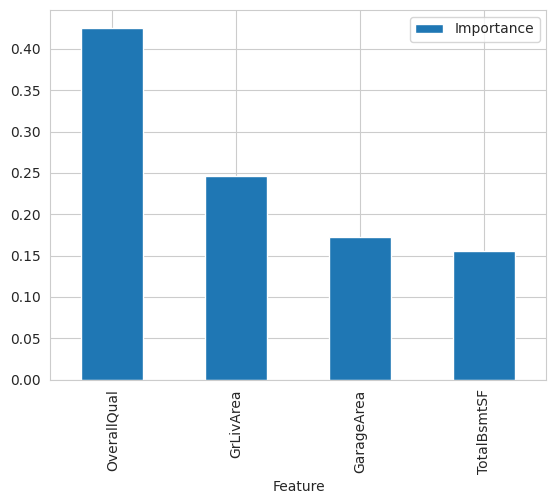

In [99]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Evaluate regressor on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.908
Mean Absolute Error: 15466.596
Mean Squared Error: 565591293.042
Root Mean Squared Error: 23782.163


* Test Set
R2 Score: 0.809
Mean Absolute Error: 21515.413
Mean Squared Error: 1317398553.139
Root Mean Squared Error: 36295.985




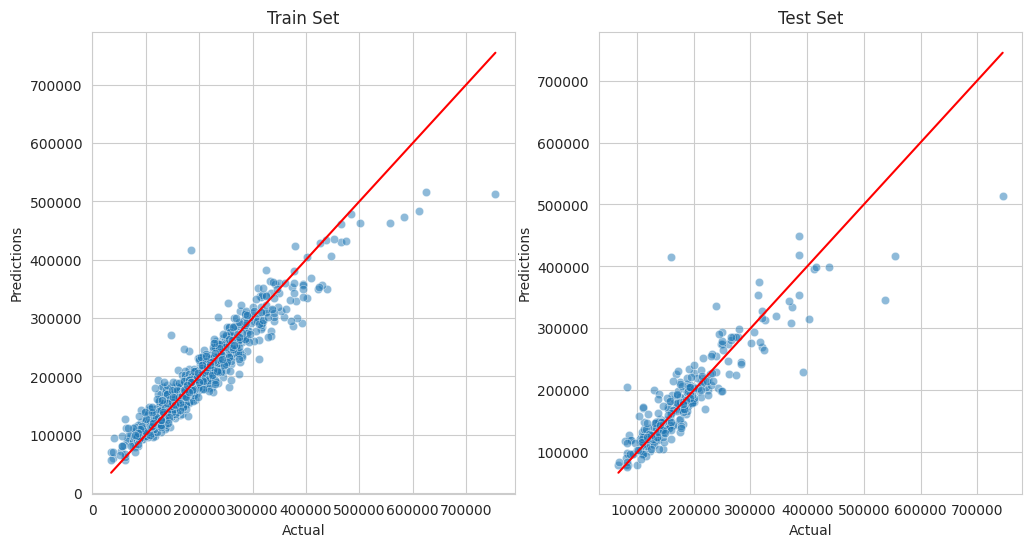

In [100]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

* This model performs best, with lower errors in the MAE, MSE and RMSE and higher R2 scores for each set. 

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [103]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [104]:
X_train.head()

,OverallQual,TotalBsmtSF,GarageArea,GrLivArea
618,9,1822,774,1828
870,5,894,308,894
92,5,876,432,964
817,8,1568,857,1689
302,7,1541,843,1541


In [105]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [106]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [107]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target


In [108]:
X_test.head()

,OverallQual,TotalBsmtSF,GarageArea,GrLivArea
529,6,2035,484,2515
491,6,806,240,1578
459,5,709,352,1203
279,7,1160,505,2022
655,6,525,264,1092


In [109]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [110]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [111]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [112]:
best_regressor_pipeline

Pipeline(steps=[('yeo_johnson', YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     n_estimators=300, random_state=0))])

In [113]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/best_regressor_pipeline.pkl']

## Feature importance plot

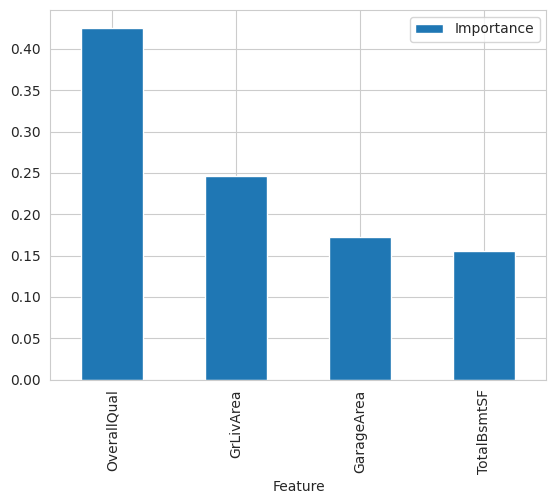

In [115]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

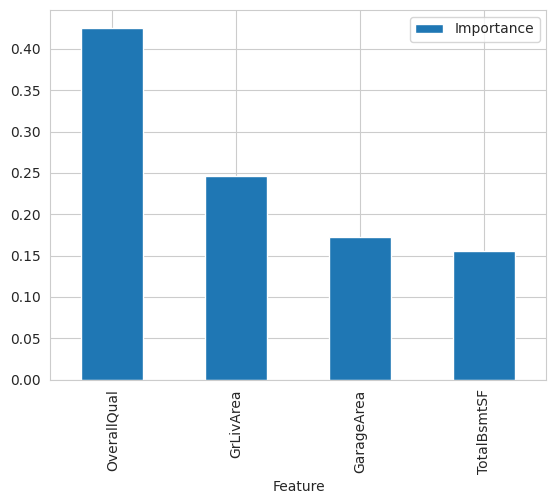

In [116]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')